<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [7]:
ticker = "PYPL"
look_back = 5 # 5 days
max_data_size = 730 # 2 years
split_percent = 0.90 # use 90 of the data  for train
zoom = 180 # last 180 days see in chart

In [8]:
stock_api_response = pd.read_json('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T')
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);
#print(list(stock_api_data.items()))
data = []
for key, value in stock_api_data.items():
  data.append([
      key,
      value.get('1. open'),
      value.get('2. high'),
      value.get('3. low'),
      value.get('5. adjusted close'),
      value.get('6. volume')
      ])

last_data =  str(data[0][0])
print(data[0])
if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
print('data size:',len(data), 'max_data_size:', max_data_size)

['2021-10-20', '273.0', '273.51', '253.1', '258.36', '31271743']
data size: 730 max_data_size: 730


In [9]:
df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close','Volume'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

657

In [10]:
df_train = df.iloc[:split]
df_test = df.iloc[split:]

trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace4 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + str(data[-1][1]) + ' High:' + str(data[-1][2]) + ' Low:' + str(data[-1][3]) + ' Close:' + str(data[-1][4]),
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)



fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()

    Open    High      Low  Close
0  81.00  82.000  80.2050  81.97
1  82.27  86.000  81.9496  85.98
2  85.37  85.675  83.7900  84.26
3  84.39  85.860  83.6600  85.81
4  87.29  88.840  87.1900  87.98
(657, 4)


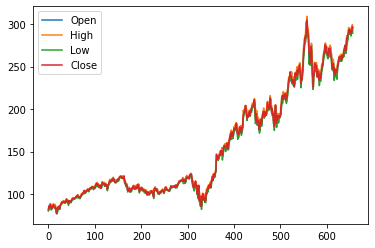

In [11]:
#Variables for training
#Date and volume columns are not used in training. 
df_for_training = df_train[['Open','High','Low','Close']].astype(float)
print(df_for_training.head())

df_for_plot=df_for_training
df_for_plot.plot.line()
print(df_for_training.shape)

In [12]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [13]:
def create_LSTM_input(df_with_features,n_past=6):
  #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
  #In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

  #Empty lists to be populated using formatted training data
  trainX = []
  trainY = []

  n_future = 1   # Number of days we want to look into the future based on the past days.
  n_past = 14  # Number of past days we want to use to predict the future.

  #Reformat input data into a shape: (n_samples x timesteps x n_features)
  #In my example, my df_with_features has a shape (12823, 4)
  #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
  for i in range(n_past, len(df_with_features) - n_future +1):
      trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
      trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

  trainX, trainY = np.array(trainX), np.array(trainY)

  print('trainX shape == {}.'.format(trainX.shape))
  print('trainY shape == {}.'.format(trainY.shape))
  return trainX, trainY

In [14]:
trainX, trainY = create_LSTM_input(df_for_training_scaled,14)

trainX shape == (643, 14, 4).
trainY shape == (643, 1).


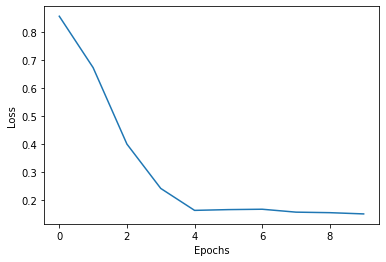

In [16]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


#model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[1]))

model.compile(
    loss=MAE,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mae"]
)
  
#model.summary()


# fit the model
modelo = model.fit(trainX, trainY, epochs=10, verbose=0)

plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days
train_dates = pd.to_datetime(df_train['Date'])
print(df_train.head())
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

         Date   Open    High      Low  Close    Volume  50MA  100MA  200MA
0  2018-11-27   81.0    82.0   80.205  81.97   5335151   NaN    NaN    NaN
1  2018-11-28  82.27    86.0  81.9496  85.98   9341953   NaN    NaN    NaN
2  2018-11-29  85.37  85.675    83.79  84.26   6516560   NaN    NaN    NaN
3  2018-11-30  84.39   85.86    83.66  85.81  11273280   NaN    NaN    NaN
4  2018-12-03  87.29   88.84    87.19  87.98  10822485   NaN    NaN    NaN
[Timestamp('2021-06-16 00:00:00', freq='C'), Timestamp('2021-06-17 00:00:00', freq='C'), Timestamp('2021-06-18 00:00:00', freq='C'), Timestamp('2021-06-21 00:00:00', freq='C'), Timestamp('2021-06-22 00:00:00', freq='C'), Timestamp('2021-06-23 00:00:00', freq='C'), Timestamp('2021-06-24 00:00:00', freq='C'), Timestamp('2021-06-25 00:00:00', freq='C'), Timestamp('2021-06-28 00:00:00', freq='C'), Timestamp('2021-06-29 00:00:00', freq='C'), Timestamp('2021-06-30 00:00:00', freq='C'), Timestamp('2021-07-01 00:00:00', freq='C'), Timestamp('2021-07-02

In [21]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction
print(prediction)
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

[[1.6387877]
 [1.6455823]
 [1.6509649]
 [1.6604394]
 [1.6676525]
 [1.6818479]
 [1.692843 ]
 [1.7072743]
 [1.7218007]
 [1.7365922]
 [1.7504482]
 [1.76167  ]
 [1.7713996]
 [1.7848384]
 [1.804082 ]]
[260.96613 261.39978 261.7433  262.348   262.80835 263.71432 264.41608
 265.33713 266.26422 267.20825 268.0926  268.80878 269.42975 270.28745
 271.51562]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



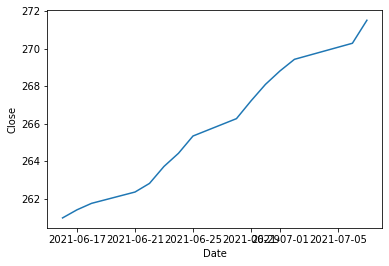

In [22]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df_train[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-8-1']

#ns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])